# **3D CNN from CT**

# Set up

In [1]:
import os
import zipfile
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.utils.model_zoo
import torch.nn.functional
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(42)
np.random.seed(42)



# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

# Downroad data

In [6]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
try :
  torch.utils.model_zoo.load_url(url, file_name=filename)
except :
  pass

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
try :
  torch.utils.model_zoo.load_url(url, file_name=filename)
except :
  pass

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")
  

# Preprocessing

In [7]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    # Reshape to (Depth, Height, Width)
    volume = volume.reshape((volume.shape[-1],volume.shape[1],volume.shape[0]))
    volume = np.expand_dims(volume, axis = 0)
    return volume

In [8]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))


CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [9]:
  # Read and process the scans.
  # Each scan is resized across height, width, and depth and rescaled.
  abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
  normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

  # For the CT scans having presence of viral pneumonia
  # assign 1, for the normal ones assign 0.
  abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))],dtype = np.float32)
  normal_labels = np.array([0 for _ in range(len(normal_scans))],dtype = np.float32)

  # Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


# Data to Data loader

In [10]:
  # Split data in the ratio 70-30 for training and validation.
x_train = torch.from_numpy(np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0))
y_train = torch.from_numpy(np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0))
x_val = torch.from_numpy(np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0))
y_val = torch.from_numpy(np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0))
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [11]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

valid_dataset = TensorDataset(x_val, y_val)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=True)

# Hyperparameter set up 

In [12]:
learning_rate = 0.0001
training_epochs = 60

# 3D-CNN model defination

In [13]:
class cnn_3d_model(torch.nn.Module):

    def __init__(self):
        super(cnn_3d_model, self).__init__()

        # 첫번째층
        # ImgIn shape=(128, 128, 64,1)
        #    Conv     -> (126,126,62,64)
        #    Pool     -> (61,61,31,64)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(kernel_size=2, stride=2),
            torch.nn.BatchNorm3d(num_features = 64)
            )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(64, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(kernel_size=2, stride=2),
            torch.nn.BatchNorm3d(num_features = 64)
            )
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(64, 128, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(kernel_size=2, stride=2),
            torch.nn.BatchNorm3d(num_features = 128)
            )    
        
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(128, 256, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(kernel_size=2, stride=2),
            torch.nn.BatchNorm3d(num_features = 256)
            )
        
        # global average pool 은 forward에서 


        self.layer_fc1 = torch.nn.Sequential(
            torch.nn.Linear(256, 512),
            torch.nn.ReLU() 
        )

        self.layer_fc2 = torch.nn.Sequential(
            torch.nn.Linear(512, 1),
            torch.nn.Sigmoid() 
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.shape[0],-1, 256)   # globalaveragepooling 과정1
        out = torch.mean(out,1)   # globalaveragepooling 과정2
        out = self.layer_fc1(out)
        out = torch.nn.Dropout(p=0.3)(out)
        out = self.layer_fc2(out)
        return out

In [14]:
model = cnn_3d_model().to(device)

In [15]:
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Model training

In [16]:
losses = []
losses_val = []
acc_val = []

for epoch in range(training_epochs):
    avg_cost = 0
    train_len = len(train_dataloader)
    val_len = len(valid_dataloader)

    for X, Y in train_dataloader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis.ravel(), Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / train_len

    losses.append(avg_cost.cpu().item())

    with torch.no_grad():
      avg_cost = 0
      correct = 0
      for X, Y in valid_dataloader:
        X = X.to(device)
        Y = Y.to(device)
        
        hypothesis = model(X)
        cost = criterion(hypothesis.ravel(), Y)

        avg_cost += cost / val_len

        predicted = (hypothesis > 0.5).float().ravel()
        correct += (predicted == Y).sum().item()

      acc_val.append(correct)

      losses_val.append(avg_cost.cpu().item())

# Visualizing model peformance

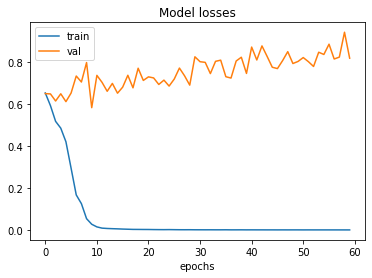

In [17]:
plt.plot(losses)
plt.plot(losses_val)
plt.title("Model losses")
plt.xlabel("epochs")
plt.legend(["train", "val"])

In [18]:
print(losses)

[0.6543663144111633, 0.5938421487808228, 0.5186691284179688, 0.48618829250335693, 0.4212808310985565, 0.29499080777168274, 0.16732238233089447, 0.1255372315645218, 0.05378536880016327, 0.02717483602464199, 0.014542736113071442, 0.008652628399431705, 0.0070057217963039875, 0.006024312227964401, 0.005189049988985062, 0.004144356586039066, 0.00337474187836051, 0.0026138066314160824, 0.0024639067705720663, 0.002238695975393057, 0.0021378719247877598, 0.0017472892068326473, 0.0015237025218084455, 0.001394066959619522, 0.0016134688630700111, 0.0013023224892094731, 0.0010209624888375401, 0.0009546399232931435, 0.0010399010498076677, 0.0007951704901643097, 0.000719545700121671, 0.0006734512862749398, 0.000715513713657856, 0.0006183492951095104, 0.0005891704349778593, 0.0007474441663362086, 0.00045396448695100844, 0.00047615895164199173, 0.0005724576767534018, 0.0003933701664209366, 0.0004587310249917209, 0.00038177231908775866, 0.0003927731013391167, 0.0003103408089373261, 0.000329526024870574

In [19]:
print(losses_val)

[0.6512513160705566, 0.649832010269165, 0.6160213351249695, 0.6504666209220886, 0.6129375100135803, 0.6540293097496033, 0.7353602051734924, 0.706746518611908, 0.7995836138725281, 0.5841560363769531, 0.7384980320930481, 0.705078125, 0.6623814105987549, 0.7000252604484558, 0.6532990336418152, 0.6821689009666443, 0.7388709783554077, 0.678920567035675, 0.7725740075111389, 0.7142384052276611, 0.7313124537467957, 0.7262195348739624, 0.6950087547302246, 0.7157377004623413, 0.6873143911361694, 0.7209304571151733, 0.7734092473983765, 0.736181378364563, 0.6918277144432068, 0.8272223472595215, 0.8037008047103882, 0.8006280064582825, 0.7469380497932434, 0.8055111765861511, 0.8110479116439819, 0.732043981552124, 0.7255829572677612, 0.8070003986358643, 0.825093686580658, 0.747673749923706, 0.8736386299133301, 0.811937153339386, 0.8791720271110535, 0.8290286660194397, 0.7772582173347473, 0.7708500623703003, 0.8088208436965942, 0.8517481684684753, 0.7949835658073425, 0.8050468564033508, 0.823524534702

In [20]:
print(model)

cnn_3d_model(
  (layer1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer4): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2